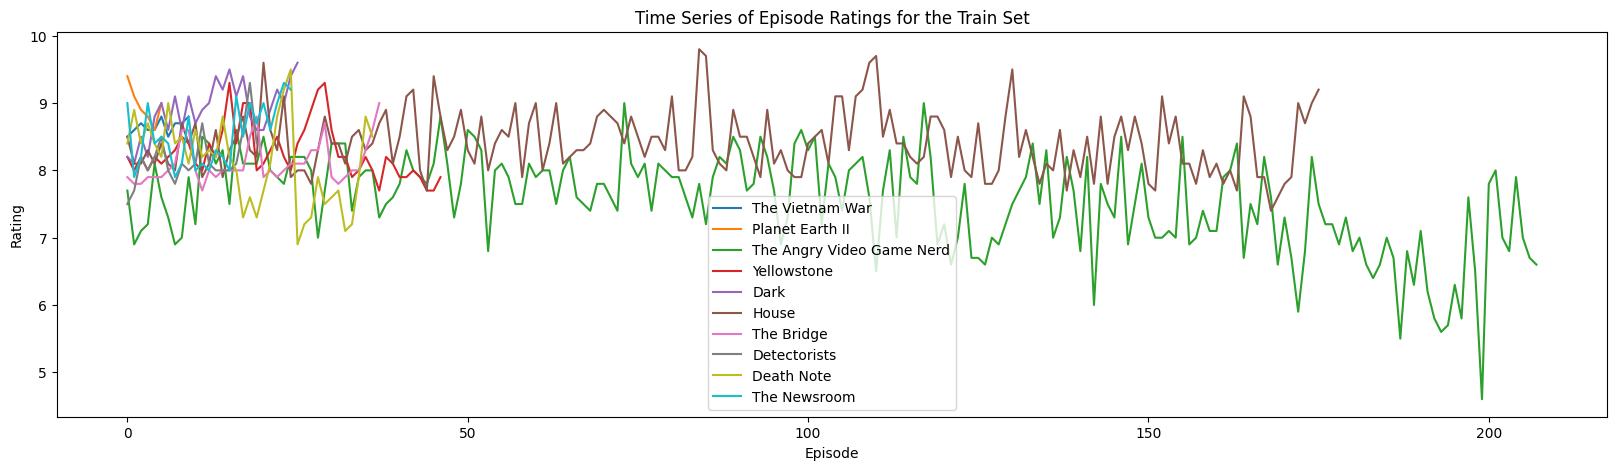

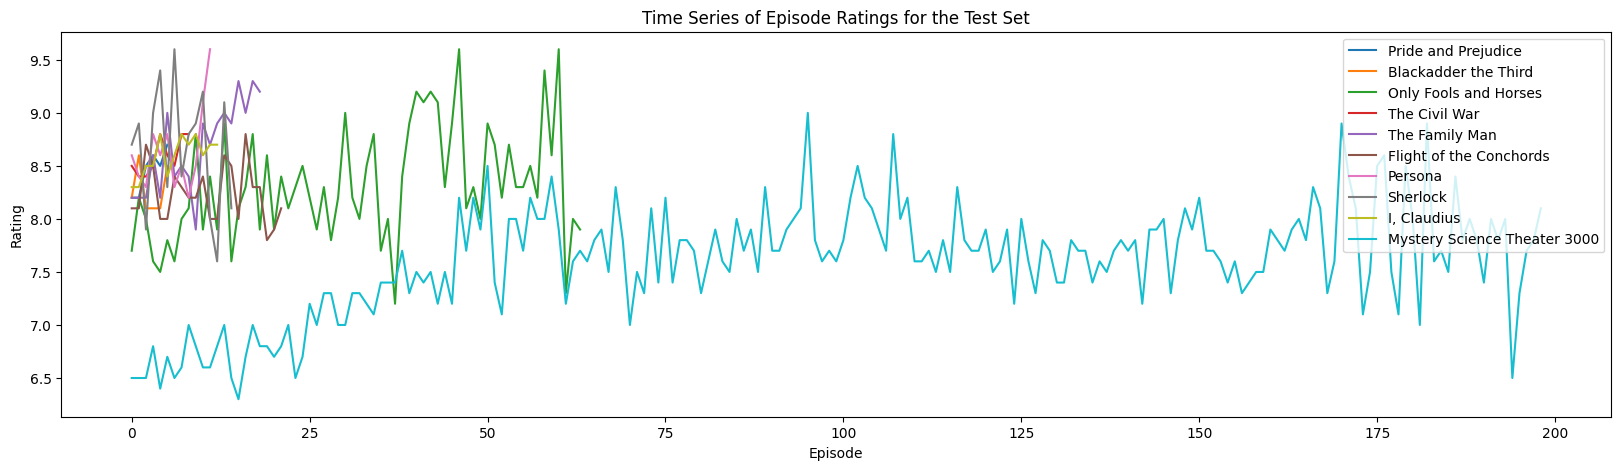

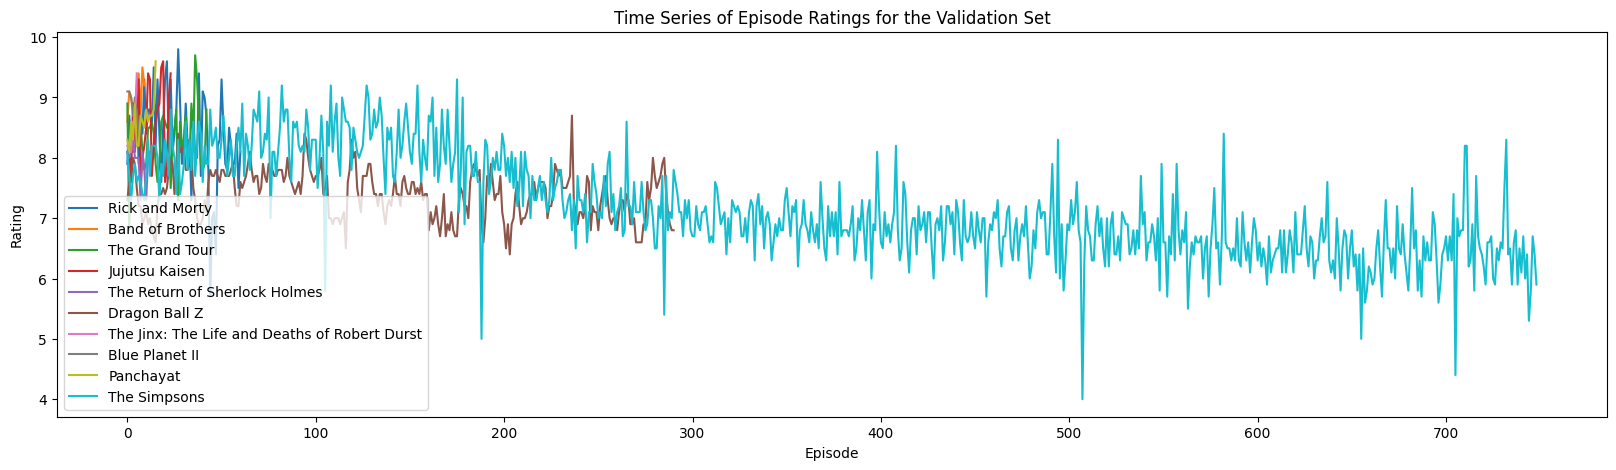

In [4]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


def load_data():
    # Load the CSV files into separate dataframes
    series_episode_ratings = pd.read_csv('./data/imdb_top_250_series_episode_ratings.csv')
    series_global_ratings = pd.read_csv('./data/imdb_top_250_series_global_ratings.csv')

    # Rename the 'Rating' columns in both dataframes
    series_episode_ratings.rename(columns={'Rating': 'Episode Rating'}, inplace=True)
    series_episode_ratings.drop(columns=['Title'], inplace=True)
    series_global_ratings.rename(columns={'Rating': 'Global Rating'}, inplace=True)

    # Merge the two dataframes into a single dataframe using the 'Code' column as the key
    merged_df = pd.merge(series_episode_ratings, series_global_ratings, on='Code')

    # Set the hierarchical index with 'Code', 'Season', 'Episode', and 'Title' as the levels
    merged_df.set_index(['Code', 'Season', 'Episode', 'Title'], inplace=True)

    # Sort the dataset by series and episode in ascending order
    merged_df.sort_index(level=['Code', 'Season', 'Episode'], ascending=[True, True, True], inplace=True)

    return merged_df

def create_timeseries(dataset):
    timeseries = dataset.reset_index()
    timeseries = timeseries.groupby(['Code', 'Title', 'Global Rating'])['Episode Rating'].apply(list).reset_index()
    return timeseries

def plot_samples(timeseries, title):
    plt.figure(figsize=(20, 5))
    # Plot the time series for the first 10 series
    for i in range(10):
        series_data = timeseries.iloc[i]
        series_title = series_data['Title']
        ratings = series_data['Episode Rating']
        
        plt.plot(ratings, label=series_title)

    plt.xlabel('Episode')
    plt.ylabel('Rating')
    plt.title(title)
    plt.legend()
    plt.show()


# Load the dataset
dataset = load_data()

timeseries = create_timeseries(dataset)

#print(dataset)
#print(timeseries)

# Split the timeseries into train, test, and validation sets
train_data, test_data = train_test_split(timeseries, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Plot the samples in the train set with a title
plot_samples(train_data, 'Time Series of Episode Ratings for the Train Set')

# Plot the samples in the test set with a title
plot_samples(test_data, 'Time Series of Episode Ratings for the Test Set')

# Plot the samples in the validation set with a title
plot_samples(val_data, 'Time Series of Episode Ratings for the Validation Set')


In [5]:
def create_dataset(timeseries):
    # Filter out series with less than 10 episodes
    filtered_timeseries = timeseries[timeseries['Episode Rating'].apply(len) >= 10]
    
    # Extract input features (ratings) and target variable (number of episodes)
    X = filtered_timeseries['Episode Rating'].apply(lambda x: x[:10]).tolist()
    y = filtered_timeseries['Episode Rating'].apply(len).tolist()

    # Create a TensorFlow dataset from the features and target
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    return dataset

def print_dataset(dataset, num_examples=5):
    iterator = iter(dataset)
    
    for i in range(num_examples):
        X, y = next(iterator)
        print("Example", i+1)
        print("Input Features (Ratings):", X)
        print("Target Variable (Number of Episodes):", y)
        print()


train_dataset = create_dataset(train_data)
val_dataset = create_dataset(val_data)
test_dataset = create_dataset(test_data)

print("Examples in the train dataset:")
print_dataset(train_dataset)

print("Examples in the validation dataset:")
print_dataset(val_dataset)

print("Examples in the test dataset:")
print_dataset(test_dataset)

Examples in the train dataset:
Example 1
Input Features (Ratings): tf.Tensor([8.5 8.6 8.7 8.6 8.6 8.8 8.5 8.7 8.7 8.8], shape=(10,), dtype=float32)
Target Variable (Number of Episodes): tf.Tensor(10, shape=(), dtype=int32)

Example 2
Input Features (Ratings): tf.Tensor([7.7 6.9 7.1 7.2 8.1 7.6 7.3 6.9 7.  7.9], shape=(10,), dtype=float32)
Target Variable (Number of Episodes): tf.Tensor(208, shape=(), dtype=int32)

Example 3
Input Features (Ratings): tf.Tensor([8.2 8.  8.2 8.  8.2 8.1 8.2 8.3 8.5 8.4], shape=(10,), dtype=float32)
Target Variable (Number of Episodes): tf.Tensor(47, shape=(), dtype=int32)

Example 4
Input Features (Ratings): tf.Tensor([8.2 8.1 8.5 8.2 8.8 9.  8.6 9.1 8.6 9.1], shape=(10,), dtype=float32)
Target Variable (Number of Episodes): tf.Tensor(26, shape=(), dtype=int32)

Example 5
Input Features (Ratings): tf.Tensor([8.5 8.1 8.1 8.3 8.1 8.4 8.1 8.  8.7 8.4], shape=(10,), dtype=float32)
Target Variable (Number of Episodes): tf.Tensor(176, shape=(), dtype=int32)

Ex

Epoch 1/10
22/22 [==============================] - 1s 1ms/step - loss: 11543.6240
Epoch 2/10
22/22 [==============================] - 0s 1ms/step - loss: 10650.0303
Epoch 3/10
22/22 [==============================] - 0s 2ms/step - loss: 9514.4658
Epoch 4/10
22/22 [==============================] - 0s 2ms/step - loss: 8234.7812
Epoch 5/10
22/22 [==============================] - 0s 2ms/step - loss: 7063.6016
Epoch 6/10
22/22 [==============================] - 0s 2ms/step - loss: 6431.6455
Epoch 7/10
22/22 [==============================] - 0s 2ms/step - loss: 6292.5337
Epoch 8/10
22/22 [==============================] - 0s 1ms/step - loss: 6281.2378
Epoch 9/10
22/22 [==============================] - 0s 2ms/step - loss: 6280.1089
Epoch 10/10
22/22 [==============================] - 0s 2ms/step - loss: 6280.6265


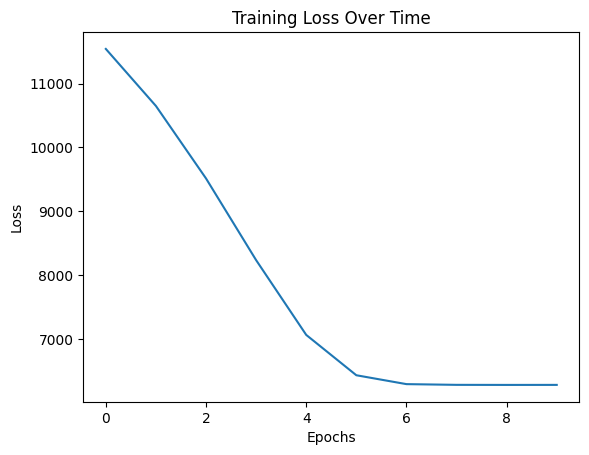

In [6]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(10, )),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model and collect the history of loss values
history = model.fit(train_dataset.batch(8), epochs=10)

# Plot the loss over time
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

(10.0, 217.0)

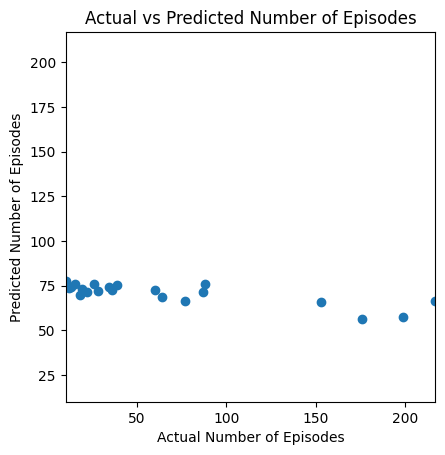

In [7]:
# Create empty lists to store actual and predicted values
actual_values = []
predicted_values = []

# Loop over the test dataset and make predictions
for X, y in test_dataset.batch(1):
    # Make prediction using the trained model
    predictions = model.predict(X, verbose=0)
    
    # Append the actual and predicted values to the respective lists
    actual_values.extend(y.numpy())
    predicted_values.extend(predictions.flatten())

# Plot scatter plot of actual vs predicted values
plt.scatter(actual_values, predicted_values)
plt.xlabel('Actual Number of Episodes')
plt.ylabel('Predicted Number of Episodes')
plt.title('Actual vs Predicted Number of Episodes')

# Set aspect ratio to 'equal' and adjust limits for both axes
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_xlim([min(actual_values + predicted_values), max(actual_values + predicted_values)])
plt.gca().set_ylim([min(actual_values + predicted_values), max(actual_values + predicted_values)])


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error

# y = np.array([1, 1, 2, 2])
# pred = np.array([0.1, 0.4, 0.35, 0.8])
# fpr, tpr, thresholds = roc_curve(y, pred, pos_label=2)
# auc(fpr, tpr)


# TODO missing step is to count TP and FP in predictions
y_true = np.array(actual_values)
y_pred = np.array(predicted_values)
y_pred = y_pred.astype(int)

cfm = confusion_matrix(y_true, y_pred)
print(cfm)

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=2)
print(fpr)
print(tpr)
print(thresholds)

# # Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

auc(fpr, tpr)
print(auc)

actual_values===================================================================
[64, 19, 22, 12, 15, 13, 199, 39, 87, 176, 28, 36, 26, 34, 77, 88, 10, 153, 60, 217, 18]
predicted_values===================================================================
[68.45418, 72.8549, 71.64559, 73.867836, 75.975655, 74.25526, 57.61487, 75.30487, 71.31454, 56.12328, 72.15117, 72.58999, 76.17021, 73.97682, 66.57581, 76.1212, 77.65813, 65.60682, 72.71599, 66.32632, 69.7164]
y_true===================================================================
[ 64  19  22  12  15  13 199  39  87 176  28  36  26  34  77  88  10 153
  60 217  18]
y_pred===================================================================
[68 72 71 73 75 74 57 75 71 56 72 72 76 73 66 76 77 65 72 66 69]
confusion_matrix===================================================================
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0.         0.04761905 0.2380952

C:\Users\rudol\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


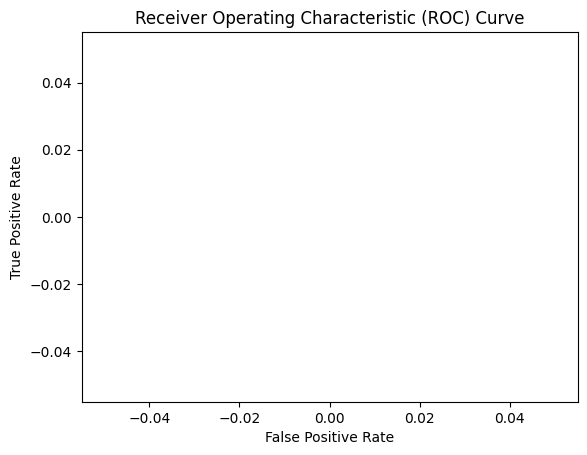

<function auc at 0x000001718E7042C0>


In [8]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error

# y = np.array([1, 1, 2, 2])
# pred = np.array([0.1, 0.4, 0.35, 0.8])
# fpr, tpr, thresholds = roc_curve(y, pred, pos_label=2)
# auc(fpr, tpr)

print("actual_values===================================================================")
print(actual_values)
print("predicted_values===================================================================")
print(predicted_values)

# TODO missing step is to count TP and FP in predictions

y_true = np.array(actual_values)
y_pred = np.array(predicted_values)
y_pred = y_pred.astype(int)

print("y_true===================================================================")
print(y_true)
print("y_pred===================================================================")
print(y_pred)
print("confusion_matrix===================================================================")
cfm = confusion_matrix(y_true, y_pred)
print(cfm)


# y = np.array([1, 1, 2, 2])
# scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=2)
print(fpr)
print(tpr)
print(thresholds)

# # Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

auc(fpr, tpr)
print(auc)